# Exporatory Analytics of Dataset

## DS 5110
* Fall 2021
* October 3rd
* Group 10
  * Antone Edelman
  * Xin Huang
  * Robert Knuuti

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

import pandas as pd
import numpy as np

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("fa21-ds5110-group10") \
    .getOrCreate()

df = spark.read.parquet("../../data/processed/chess_games_blitz_classic.parquet")

There's some additional cleanup we have to do beyond the filtering of games to just classic and blitz.
Below are our transforms to add new features and to transform the data.

In [2]:
df.printSchema()

print("Abandoned Games to drop: {}".format(df.filter(df.result.contains("*")).count()))
# Remove all abandoned games.
df_filtered = df.filter(~df.result.contains("*"))

from fractions import Fraction as frac

# Convert result column into seperate white/black win columns
white_win_udf = F.udf(lambda result: float(frac(result.split('-')[0])), T.DoubleType())
black_win_udf = F.udf(lambda result: float(frac(result.split('-')[1])), T.DoubleType())

# We break apar the AN notation for chess moves into arrays
def movetype(x):
    import re
    moves = re.split('\d+\. ', x)[1:]
    return [x.strip() for x in moves]

# We establish a bin rate to determine the complexity of a match (based on number of moves)
def bin_moves(x):
    if x == 1:
        return 1
    elif x <= 10:
        return 2
    elif x <= 20:
        return 3
    elif x <= 30:
        return 4
    elif x <= 40:
        return 5
    elif x <= 50:
        return 6
    else:
        return 7

udf_movetype = F.udf(lambda x: movetype(x), T.ArrayType(T.StringType()))
df_filtered = df_filtered.withColumn('moves', udf_movetype(F.col('AN')))

# Calculate the total number of moves in a game
count_udf  = F.udf(lambda result: len(result), T.IntegerType())
game_complexity_udf = F.udf(lambda result: bin_moves(result), T.IntegerType())

df_filtered = df_filtered.withColumn("white_games_won", white_win_udf(df_filtered.result))
df_filtered = df_filtered.withColumn("black_games_won", black_win_udf(df_filtered.result))
df_filtered = df_filtered.withColumn("tie", df_filtered.white_games_won == df_filtered.black_games_won)
df_filtered = df_filtered.withColumn("result_moves", count_udf(df_filtered.moves))
df_filtered = df_filtered.withColumn("game_complexity", game_complexity_udf(df_filtered.result_moves))

print("Refined schema\n-------------------")
df_filtered.printSchema()

root
 |-- event: string (nullable = true)
 |-- white: string (nullable = true)
 |-- black: string (nullable = true)
 |-- result: string (nullable = true)
 |-- UTCDate: date (nullable = true)
 |-- UTCTime: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)

Abandoned Games to drop: 739
Refined schema
-------------------
root
 |-- event: string (nullable = true)
 |-- white: string (nullable = true)
 |-- black: string (nullable = true)
 |-- result: string (nullable = true)
 |-- UTCDate: date (nullable = true)
 |-- UTCTime: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: d

## Number of records

In [3]:
print(f"Total number of records are: {df.count()}")

Total number of records are: 3850385


Reviewing our dataset, we found that games which were abandoned had a value of "\*" for the results.
Given the total number of abandonded records are small in comparison to the others, we chose to drop these from our dataset.


In [4]:
print("Total records: {}".format(df_filtered.count()))

Total records: 3849646


## Number of columns

In [5]:
print(f"Total number of columns are: {len(df_filtered.columns)}")

Total number of columns are: 21


## Statistical Summary of Response Variable

In [6]:
df_filtered.select(["white_games_won", "black_games_won"]).describe().show()

+-------+------------------+------------------+
|summary|   white_games_won|   black_games_won|
+-------+------------------+------------------+
|  count|           3849646|           3849646|
|   mean|0.5174984920691409|0.4825015079308591|
| stddev|0.4893233465605675|0.4893233465605674|
|    min|               0.0|               0.0|
|    max|               1.0|               1.0|
+-------+------------------+------------------+



## Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)

*Note*: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.

In [7]:
df_filtered.select(["WhiteElo", "BlackElo", "result_moves", "game_complexity", "ECO", "TimeControl"]).describe().show()

+-------+------------------+------------------+------------------+------------------+-------+-----------+
|summary|          WhiteElo|          BlackElo|      result_moves|   game_complexity|    ECO|TimeControl|
+-------+------------------+------------------+------------------+------------------+-------+-----------+
|  count|           3849646|           3849646|           3849646|           3849646|3849646|    3849646|
|   mean| 1710.584323078018| 1708.761483263656| 33.67180099157169| 4.713608212287571|   null|       null|
| stddev|263.42156710132883|264.54823496140455|16.135177630271578|1.4317312876052417|   null|       null|
|    min|               762|               728|                 1|                 1|    A00|       0+10|
|    max|              2906|              2907|               265|                 7|    E99|     960+90|
+-------+------------------+------------------+------------------+------------------+-------+-----------+



## Include up to five helpful graphs

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

df_games_per_date = df_filtered.groupBy(["UTCDate"]).count().sort("UTCDate")

+----------+------+
|   UTCDate| count|
+----------+------+
|2016-01-01|122509|
|2016-01-02|118505|
|2016-01-03|125872|
|2016-01-04|126164|
|2016-01-05|126510|
|2016-01-06|123911|
|2016-01-07|120516|
|2016-01-08|120251|
|2016-01-09|121369|
|2016-01-10|118696|
|2016-01-11|125050|
|2016-01-12|126923|
|2016-01-13|123122|
|2016-01-14|124756|
|2016-01-15|119807|
|2016-01-16|117771|
|2016-01-17|122558|
|2016-01-18|124395|
|2016-01-19|126099|
|2016-01-20|124523|
|2016-01-21|124697|
|2016-01-22|123922|
|2016-01-23|121811|
|2016-01-24|125713|
|2016-01-25|128957|
|2016-01-26|129451|
|2016-01-27|130184|
|2016-01-28|130266|
|2016-01-29|126155|
|2016-01-30|132878|
|2016-01-31|116305|
+----------+------+



Text(0.5, 1.0, 'Events per Day')

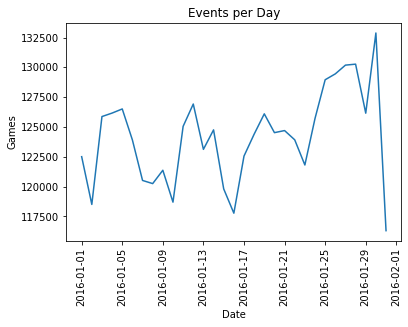

In [9]:
df_games_per_date.show(31)
df_pandas = df_games_per_date.toPandas()
plt.plot(df_pandas['UTCDate'], df_pandas['count'])
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Games")
plt.title("Events per Day")

Text(0.5, 1.0, 'Events per Day')

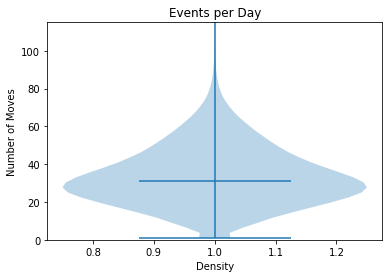

In [10]:
moves_count = df_filtered.select('result_moves').toPandas()

plt.violinplot(moves_count,
               showmeans=False,
               showmedians=True)
plt.ylim(0,115) #Note there are outliers beyond 100 moves; to be filtered in future transforms.
plt.xlabel("Density")
plt.ylabel("Number of Moves")
plt.title("Events per Day")

,white_games_won,count
0,loss,1778492
1,win,1913218
2,tie,157936


Text(0.5, 1.0, 'Game Result Summary for White')

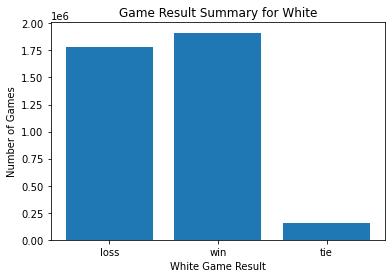

In [11]:
def label_wins(x):
    if x == 0.0:
        return 'loss'
    elif x == 0.5:
        return 'tie'
    else:
        return 'win'

white_wins = df_filtered.groupBy('white_games_won').count().toPandas()
white_wins['white_games_won'] = white_wins['white_games_won'].apply(label_wins)

display(white_wins)
plt.bar(x=white_wins['white_games_won'], height=white_wins['count'])
plt.xlabel("White Game Result")
plt.ylabel("Number of Games")
plt.title("Game Result Summary for White")

Text(0.5, 1.0, 'Complexity of Games by Count')

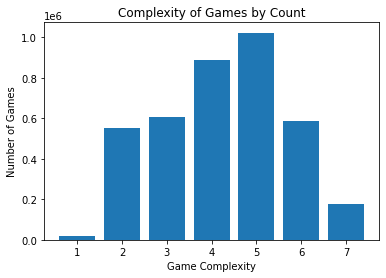

In [12]:
binned_moves = df_filtered.groupBy('game_complexity').count().toPandas()

plt.bar(x=[1,2,3,4,5,6,7], height=binned_moves['count'])
plt.xlabel("Game Complexity")
plt.ylabel("Number of Games")
plt.title("Complexity of Games by Count")